In [512]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabula
import numpy as np
%matplotlib inline
strip_first = lambda x: int(str(x)[0])
strip_first_vec = np.vectorize(strip_first)
strip_second = lambda x: int(str(x)[1])
strip_second_vec = np.vectorize(strip_second)

parser = lambda row: row.text.split('\n')[2:-1]
np.random.seed(42)

pal = sns.diverging_palette(220, 20, as_cmap=False)


<h1>Download data</h1>

In [513]:
url='https://election-county-reports-prod112020.s3.amazonaws.com/4539283c-3f09-4fdf-ad93-0bfd82d32be1/db3f9865-656b-4704-9429-bd38e726ab42/Results%20per%20Precinct%20Data%20report.pdf'
r = requests.get(url, stream=True)

with open('straight_t.pdf', 'wb') as f:
    f.write(r.content)

<h1> Parse data</h1>

<h2> Straight Ticket</h2>

In [514]:
%%capture

dfs = []
for page in [0,1,2,3,4,5,6,7,8]:
    df = tabula.read_pdf('straight_t.pdf',pages=page)
    print(df[0])
    dfs.append(df[0])
    
for idx in [2,3,4,5,6,7,8]:
    dfs[idx] = dfs[idx].drop(0)
    dfs[idx].columns = dfs[0].columns
dfs[8] = dfs[8][0:14]

In [515]:
straight_ticket = pd.concat(dfs)
straight_ticket = straight_ticket.drop_duplicates()

for idx in range(7):
    values = []
    for ii, item in enumerate(straight_ticket.iloc[:,idx+2].values):
        try:
            values.append(int(item))
        except:
            l = item.split(',')
            values.append(int(''.join(l)))
    straight_ticket.iloc[:,idx+2] = values 
    
straight_ticket['total_votes'] = straight_ticket.sum(axis=1)
straight_ticket['Rep_Percent'] = straight_ticket['Republican Party']/straight_ticket['total_votes']
straight_ticket['Dem_Percent'] = straight_ticket['Democratic Party']/straight_ticket['total_votes']

#No spaces here
straight_ticket.columns = [item.split(' ')[0] for item in straight_ticket.columns]

<h2>Other Votes</h2>

In [516]:
%%capture
dfs = []
for page in [8,9,10,11,12,13,14,15]:
    df = tabula.read_pdf('straight_t.pdf',pages=page)
    
    dfs.append(df[0])

temp = dfs.copy()

In [517]:
dfs = temp.copy()

#Parse page 0
columns = dfs[0].iloc[17]
dfs[0] = dfs[0].iloc[19:]
dfs[0].columns = columns
#Parse page idx
for idx in [1,2,3,4,5,6]:
    dfs[idx] = dfs[idx].drop([0,1])
    dfs[idx].columns = columns
dfs[7] = dfs[7].iloc[2:27]
dfs[7].columns  = columns
votes = pd.concat(dfs)

votes.columns = ['number','Precinct','Biden', 'Trump', 'Jorgensen','Blankenship',
                 'Hawkins','LaFuente','WriteIn']


In [518]:
for idx in range(7):
    values = []
    for ii, item in enumerate(votes.iloc[:,idx+2].values):
        try:
            values.append(int(item))
        except:
            l = item.split(',')
            values.append(int(''.join(l)))
    votes.iloc[:,idx+2] = values 
    
votes['total'] = votes.sum(axis=1)  
votes['Trump_Percent'] = votes['Trump']/votes['total']
votes['Biden_Percent'] = votes['Biden']/votes['total']




In [519]:
straight_ticket.sort_values('Precinct', inplace=True)
votes.sort_values('Precinct', inplace=True)

#Let's make sure our precincts are all there and aligned. 
np.sum(straight_ticket['Precinct'] == straight_ticket['Precinct'])

252

<h1>Analysis</h1>

<h2>As in the video</h2>

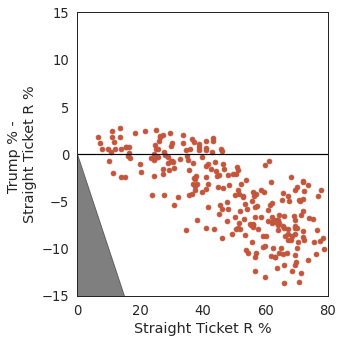

In [529]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

r_p = straight_ticket['Rep_Percent'].values
r_T = votes['Trump_Percent'].values
plt.scatter(r_p*100, (r_T-r_p)*100,color=pal[-1])
plt.ylim(-15,15)
plt.xlim(0,80)
plt.ylabel('Trump % - \nStraight Ticket R %')
plt.xlabel('Straight Ticket R %')

plt.fill_between(np.arange(100),np.repeat(-100,100),-np.arange(100),color='black',
                 alpha=.5)
plt.fill_between(np.arange(100),np.repeat(100,100),100-np.arange(100),color='black',
                 alpha=.5)
plt.plot([0,100],[0,0],color='black')
plt.tight_layout()
plt.savefig('./BenfordBS/KentCountyTrumpBadAxis.png',dpi=500)

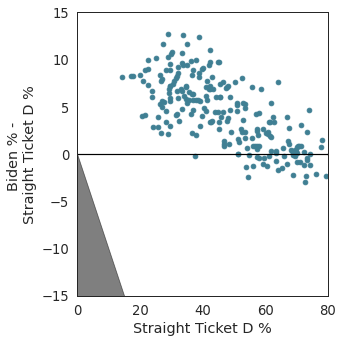

In [528]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)

r_p = straight_ticket['Dem_Percent'].values
r_T = votes['Biden_Percent'].values
plt.scatter(r_p*100, (r_T-r_p)*100,color=pal[0])
plt.ylim(-15,15)
plt.xlim(0,80)
plt.ylabel('Biden % - \nStraight Ticket D %')
plt.xlabel('Straight Ticket D %')

plt.plot([0,100],[0,0],color='black')


plt.fill_between(np.arange(100),np.repeat(-100,100),-np.arange(100),color='black',
                 alpha=.5)
plt.fill_between(np.arange(100),np.repeat(100,100),100-np.arange(100),color='black',
                 alpha=.5)
plt.tight_layout()
plt.savefig('./BenfordBS/KentCountyBidenBadAxis.png',dpi=500)

<h2>Less convoluted</h2>

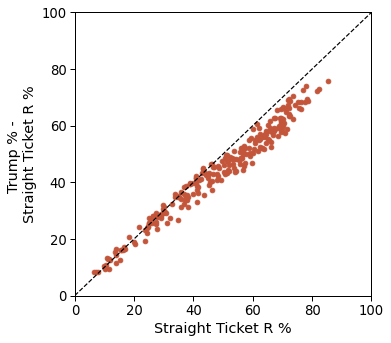

In [502]:
plt.figure(figsize=(10,5))
sns.set_context('paper',font_scale=1.5)

plt.subplot(121)
r_p = straight_ticket['Rep_Percent'].values
r_T = votes['Trump_Percent'].values
plt.scatter(r_p*100, (r_T)*100,color=pal[-1])

plt.ylabel('Trump % - \nStraight Ticket R %')
plt.xlabel('Straight Ticket R %')
plt.plot([0,100], [0,100],color='k',ls='--')

plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()

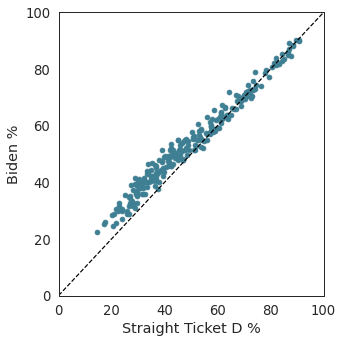

In [545]:
plt.figure(figsize=(5,5))
sns.set_context('paper',font_scale=1.5)

r_p = straight_ticket['Dem_Percent'].values
r_T = votes['Biden_Percent'].values
plt.scatter(r_p*100, (r_T)*100,color=pal[0])

plt.ylabel('Biden %')
plt.xlabel('Straight Ticket D %')
plt.plot([0,100], [0,100],color='k',ls='--')

plt.xlim(0,100)
plt.ylim(0,100)
plt.tight_layout()
plt.savefig('./BenfordBS/BidenNormalAxis.png',dpi=500)

In [530]:
np.sum(votes['Biden'])

186753

In [532]:
np.sum(votes['Trump'])

165318

Text(0.5, 0, 'Dem Straight Ticket')

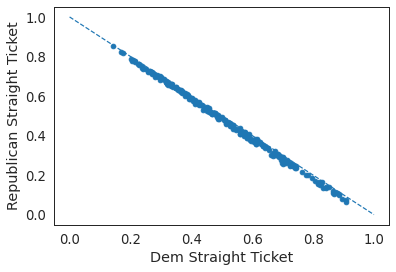

In [544]:
plt.scatter(straight_ticket['Dem_Percent'].values,
            straight_ticket['Rep_Percent'].values)
plt.plot([0,1],[1,0],ls='--')
plt.ylabel('Republican Straight Ticket')
plt.xlabel('Dem Straight Ticket')